In [96]:
#import arcpy                # the arcpy for your local Pro
import pandas
from arcgis.gis import GIS  # the submodule for displaying maps in jupyter
import arcgis               # the python api module (online processing)
from urllib import request  # module for requesting data from url
import datetime             # gets today's date and past dates
#import json
from shapely.geometry import Point # needed to create shapefiles
import geopandas
import matplotlib.pyplot as plt

import shutil, os                # needed to zip shapefiles

In [4]:
NN = 11 #number of days past to consider (present day is omitted because it may not exist yet)

In [5]:
datelist = []
dashdatelist = []
for N in range(int(NN)):
    date = datetime.datetime.now() - datetime.timedelta(days=N)
    
    year = date.year
    month = date.month
    day = date.day
    if day < 10: day_2digit = "0" + str(day)
    else: day_2digit = str(day)
    if month < 10: month_2digit = "0" + str(month)
    else: month_2digit = str(month)    
    dashdate = month_2digit + "-" + day_2digit + "-" + str(year)
    dashdatelist.append(dashdate)
    
dashdatelist

['04-11-2020',
 '04-10-2020',
 '04-09-2020',
 '04-08-2020',
 '04-07-2020',
 '04-06-2020',
 '04-05-2020',
 '04-04-2020',
 '04-03-2020',
 '04-02-2020',
 '04-01-2020']

In [11]:
def fetch(DASHDATE):
    underscoredate = DASHDATE.replace("-", "_")
    url = r"https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/" + DASHDATE +".csv"
    filename = "TEMP_" + underscoredate + ".txt"
    response = request.urlretrieve(url, filename)
    return()

In [12]:
for dashdate in dashdatelist[1:]: fetch(dashdate)

This block reads one csv, converts to shapefile and zips for upload.

In [145]:
underscoredate = dashdatelist[1].replace("-", "_")
df = pandas.read_csv('TEMP_' + underscoredate + '.txt')
df.columns = ['FIPS','Admin2','Province_State','Country_Region','Last_Update','Lat','Long','Confirmed','Deaths','Recovered','Active','Combined_Key']

i = 1
for dashdate in dashdatelist[1:]:
    underscoredate = dashdate.replace("-", "_")
    temp_df = pandas.read_csv('TEMP_' + underscoredate + '.txt')
    temp_df.columns = ['FIPS','Admin2','Province_State','Country_Region','Last_Update','Lat','Long','Confirmed','Deaths','Recovered','Active','Combined_Key']
    temp_df2 = temp_df.loc[:,'Confirmed':'Combined_Key']
    df = df.merge(temp_df2, on='Combined_Key', how='left', suffixes=('', str(i))) 
    
    i = i+1

In [146]:
import statsmodels.api as sm
from numpy import log

slopelist = []
intlist = []

for index, rows in df.iterrows(): 
    Y =[rows.Confirmed10, rows.Confirmed9, rows.Confirmed8, rows.Confirmed7, rows.Confirmed6, rows.Confirmed5, rows.Confirmed4, rows.Confirmed3, rows.Confirmed2, rows.Confirmed1, rows.Confirmed]
    logY=[]
    for y in Y: 
        if y>0: logY.append(log(y))
        else: logY.append(0)
    X = range(11)
    X = sm.add_constant(X)
    model = sm.OLS(logY,X)
    results = model.fit()
    slope = results.params[1]
    slopelist.append(slope)
    intercept = results.params[0]
    intlist.append(intercept)

slopedf = pandas.DataFrame(slopelist)
slopedf.columns = ['CSlope']
intdf = pandas.DataFrame(intlist)
intdf.columns = ['CIntercept']
df = df.join(slopedf)


In [147]:
df = df.join(intdf)

In [148]:
df.filter(regex=r'C', axis=1)[0:10]


,Country_Region,Confirmed,Combined_Key,Confirmed1,Confirmed2,Confirmed3,Confirmed4,Confirmed5,Confirmed6,Confirmed7,Confirmed8,Confirmed9,Confirmed10,CSlope,CIntercept
0,US,7,"Abbeville, South Carolina, US",7,7.0,5.0,5.0,6.0,6.0,6.0,6.0,6.0,4.0,0.030274,1.612419
1,US,94,"Acadia, Louisiana, US",94,89.0,86.0,82.0,79.0,75.0,65.0,72.0,61.0,47.0,0.058913,4.026824
2,US,12,"Accomack, Virginia, US",12,11.0,11.0,11.0,11.0,11.0,8.0,8.0,10.0,7.0,0.045605,2.078036
3,US,495,"Ada, Idaho, US",495,447.0,438.0,419.0,402.0,385.0,360.0,307.0,312.0,195.0,0.073709,5.559674
4,US,1,"Adair, Iowa, US",1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,0.000000
5,US,6,"Adair, Kentucky, US",6,6.0,3.0,3.0,3.0,3.0,3.0,NaN,NaN,NaN,0.195465,0.010708
6,US,11,"Adair, Missouri, US",11,11.0,11.0,11.0,10.0,10.0,10.0,6.0,6.0,3.0,0.100230,1.642429
7,US,26,"Adair, Oklahoma, US",26,25.0,25.0,25.0,20.0,18.0,14.0,14.0,9.0,8.0,0.121494,2.266502
8,US,475,"Adams, Colorado, US",475,417.0,417.0,388.0,367.0,354.0,294.0,260.0,212.0,181.0,0.093263,5.345304
9,US,1,"Adams, Idaho, US",1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,0.000000,0.000000


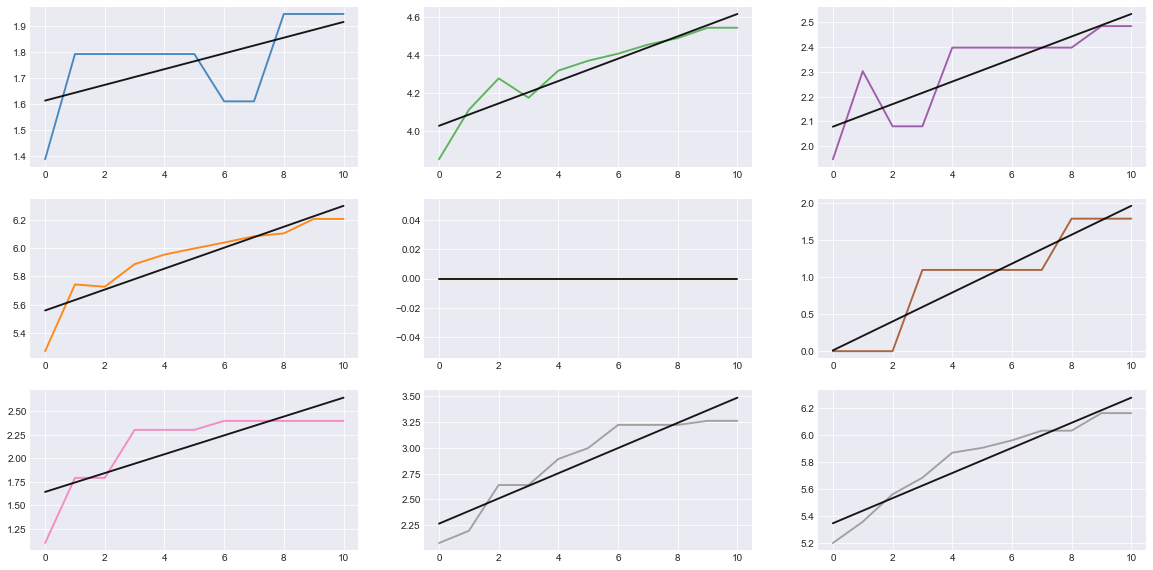

In [149]:
# Initialize the figure
plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(20,10)) 
# create a color palette
palette = plt.get_cmap('Set1')
num = 0
for index, rows in df[0:9].iterrows(): 
    Y =[rows.Confirmed10, rows.Confirmed9, rows.Confirmed8, rows.Confirmed7, rows.Confirmed6, rows.Confirmed5, rows.Confirmed4, rows.Confirmed3, rows.Confirmed2, rows.Confirmed1, rows.Confirmed]
    logY=[]
    for y in Y: 
        if y>0: logY.append(log(y))
        else: logY.append(0)
    X = range(11)
    slope = rows.CSlope
    intercept = rows.CIntercept
    Yhat = []
    for x in X:
        yhat = slope*x + intercept
        Yhat.append(yhat)
 
# multiple line plot
    num+=1
 
    # Find the right spot on the plot
    plt.subplot(3,3, num)
 
    # Plot the lineplot
    
    
    plt.plot(X, logY, marker='', color=palette(num), linewidth=1.9, alpha=0.9)
    plt.plot(X, Yhat, color='black', linewidth=1.9, alpha=0.9)

In [150]:
df.to_csv(r"SLOPES.txt")